# Clasificación

## Práctica

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

El dataset contiene datos relacionados con las campañas de marketing dirigidas (llamadas telefónicas) de una entidad bancaria portuguesa. El objetivo de la clasificación es predecir si el cliente suscribirá (1/0) un depósito a plazo (variable y).

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv')

El conjunto de datos proporciona la información de los clientes del banco. Incluye 41.188 registros y 21 campos.

In [3]:
data = data.dropna()
print(data.shape)
print(data.columns)

(41188, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')


In [4]:
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1


**Variables de entrada**

*   edad (numérica)
*   trabajo : tipo de trabajo (categórico: "administrativo", "obrero", "empresario", "empleado doméstico", "directivo", "jubilado", "autónomo", "servicios", "estudiante", "técnico", "desempleado", "desconocido")
* marital : estado civil (categórico: "divorciado", "casado", "soltero", "desconocido")
* educación (categórica: "básico.4y", "básico.6y", "básico.9y", "bachillerato", "analfabeto", "curso.profesional", "título.universitario", "desconocido")
* morosidad: ¿tiene crédito en mora? (categórico: "no", "sí", "desconocido")
* vivienda: ¿tiene préstamo para la vivienda? (categórico: "no", "sí", "desconocido")
* préstamo: ¿tiene un préstamo personal? (categórico: "no", "sí", "desconocido")
* contacto: tipo de comunicación del contacto (categórico: "celular", "teléfono")
* mes: último mes del año del contacto (categórico: "ene", "feb", "mar", ..., "nov", "dec")
* día_de_la_semana: día de la semana del último contacto (categórico: "mon", "tue", "wed", "thu", "fri")
* duración: duración del último contacto, en segundos (numérico). Nota importante: este atributo afecta en gran medida al objetivo de salida (por ejemplo, si duration=0 entonces y='no'). La duración no se conoce antes de que se realice una llamada, además, tras el final de la llamada, y obviamente se conoce. Por lo tanto, esta entrada sólo debería incluirse a efectos de referencia y debería descartarse si se pretende tener un modelo predictivo realista
* campaña: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)
* pdays: número de días transcurridos desde que se contactó por última vez con el cliente en una campaña anterior (numérico; 999 significa que no se contactó con el cliente previamente)
* anterior: número de contactos realizados antes de esta campaña y para este cliente (numérico)
* poutcome: resultado de la campaña de marketing anterior (categórico: "fracaso", "inexistente", "éxito")
* emp.var.rate: tasa de variación del empleo - (numérico)
* cons.price.idx: índice de precios al consumo - (numérico)
* cons.conf.idx: índice de confianza del consumidor - (numérico)
* euribor3m: índice euribor a 3 meses - (numérico)
* nr.employed: número de empleados - (numérico)

**Variable de predicción (objetivo deseado):**
y - ¿ha suscrito el cliente un depósito a plazo? (binario: "1", significa "Sí", "0" significa "No")

### Pre-processing + EDA

La columna de educación del conjunto de datos tiene muchas categorías y necesitamos reducir las categorías para una mejor modelización. La columna de educación tiene las siguientes categorías:

In [5]:
data.education.unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [6]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [7]:
data.education.unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [8]:
data.y.value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

In [9]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("porcentaje de no subscripcion: ", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("porcentaje de subscripcion", pct_of_sub*100)

porcentaje de no subscripcion:  88.73458288821988
porcentaje de subscripcion 11.265417111780131


Nuestras clases están desequilibradas, y la proporción de instancias sin suscripción y con suscripción es de 89:11. Antes de seguir adelante con el equilibrio de las clases, vamos a hacer un poco más de exploración.

In [10]:
# data.groupby("y").mean() # esta celda me da un error con la cálculo de la media

**Observaciones:**

*   La edad media de los clientes que compraron el depósito a 
plazo es mayor que la de los clientes que no lo hicieron.
*   El pdays (días transcurridos desde que se contactó con el cliente por última vez) es comprensiblemente más bajo para los clientes que lo compraron. Cuanto más bajo sea el pdays, mejor será el recuerdo de la última llamada y, por tanto, mayores serán las posibilidades de venta.
*  Sorprendentemente, las campañas (número de contactos o llamadas realizadas durante la campaña actual) son menores para los clientes que compraron el depósito a plazo.

### Visualizaciones

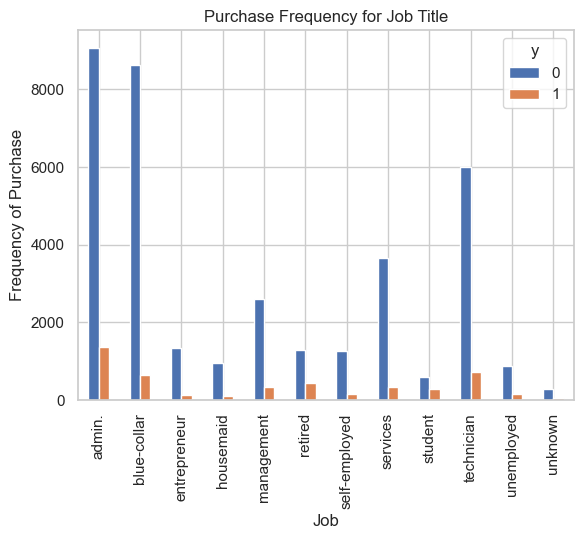

In [11]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

La frecuencia de compra del depósito depende en gran medida del cargo. Así pues, el título de trabajo puede ser un buen predictor de la variable de resultado.

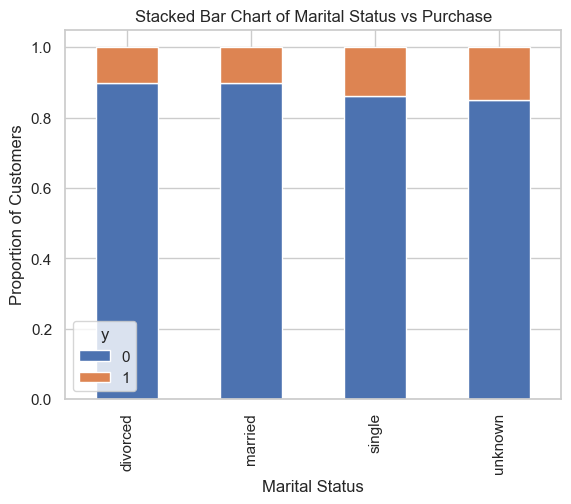

In [12]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('marital_vs_pur_stack')

El estado civil no parece ser un fuerte predictor de la variable de resultado.

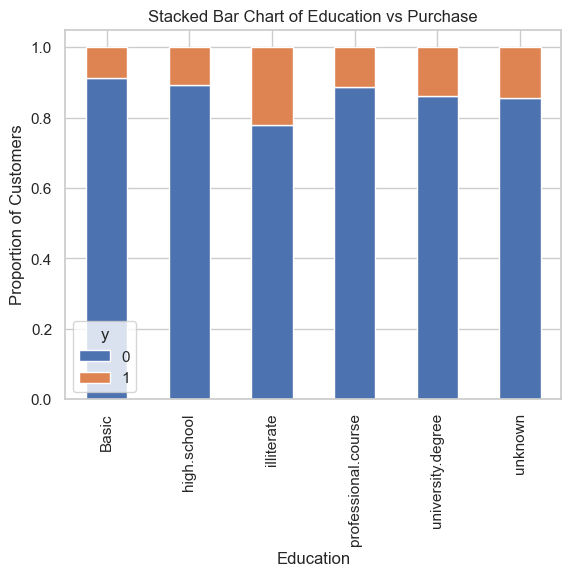

In [13]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

La educación parece ser un buen predictor de la variable de resultado.

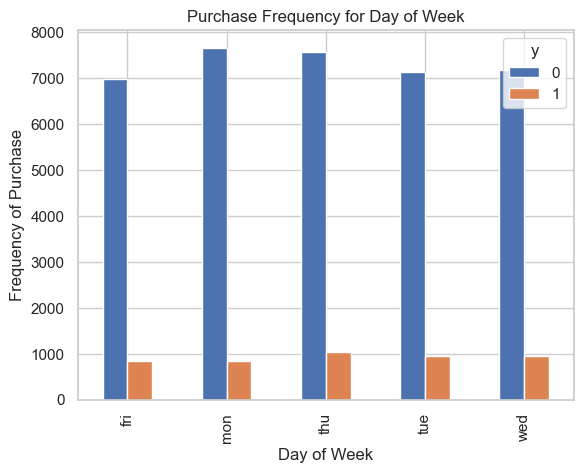

In [14]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

El día de la semana puede no ser un buen indicador del resultado.

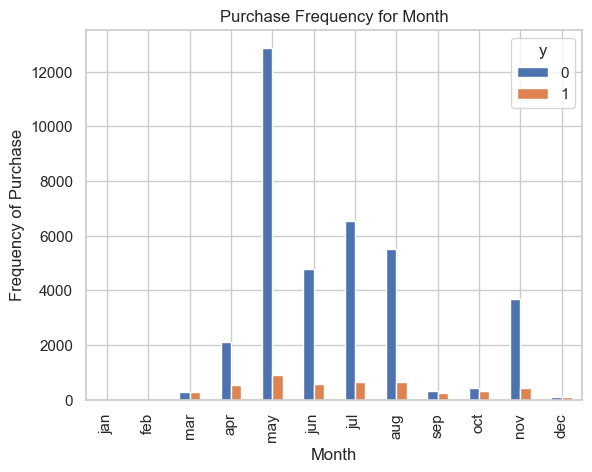

In [15]:
# agv_ Crear la tabla cruzada y reordenar los meses en la gráfica
month_order = ["jan", "feb", "mar", "apr", "may", "jun", 
               "jul", "aug", "sep", "oct", "nov", "dec"]

pd.crosstab(data.month,data.y).reindex(month_order).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')


El mes podría ser un buen predictor de la variable de resultado.

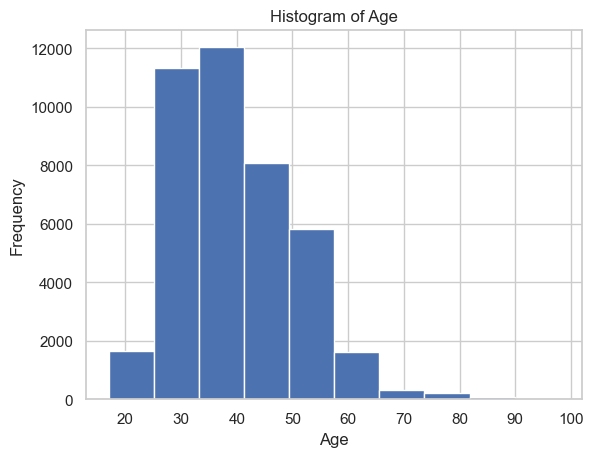

In [16]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

La mayoría de los clientes del banco en este conjunto de datos están en el rango de edad de 30-40 años.

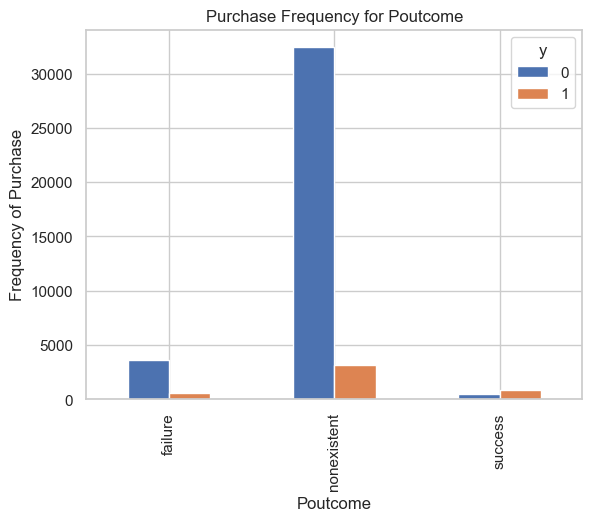

In [17]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

El Poutcome parece ser un buen predictor de la variable de resultado.

### Model fitting

In [18]:
df = data.copy()

#### Crear variables dummy

- Transformar las siguientes variables en dummies


In [19]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [21]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
#es decir, todas las que son objeto, en dummies
# Creamos las variables dummy
# usaremos drop_first=True para eliminar una de las categorías para evitar multicolinealidad, que afecta mucho al modelo de Regresión Logística
df_dummies = pd.get_dummies(df, columns=cat_vars, drop_first=True)

df_dummies.head(2)


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,False,False,False,False,False,True,False,False,True,False
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,False,True,False,False,False,False,False,False,True,False


- Guardar las demás variables en un dataframe

In [22]:
# Crea lista de variables numéricas (las que no están en cat_vars)
numeric_vars = [col for col in df.columns if col not in cat_vars]

df_numeric = df[numeric_vars]

- Separar las variables en matriz **X** y vector **y**

In [23]:
X = df_dummies.drop('y', axis=1)  # Elimina la columna 'y' y guarda todo lo demás en X
y = df_dummies['y']  # Guarda solo la columna 'y'

print("Forma de X:", X.shape, type(X))
print("Forma de y:", y.shape, type (y))

Forma de X: (41188, 51) <class 'pandas.core.frame.DataFrame'>
Forma de y: (41188,) <class 'pandas.core.series.Series'>


- Separar los datos en train y test

In [24]:
# Dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Ajustar la regresión logística

In [25]:
# Inicializar el modelo de regresión logística
log_reg = LogisticRegression(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
log_reg.fit(X_train, y_train)

/Users/angelg.villanueva/Documents/04 DATA-CB-PROGRAM/DS102024_4/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

- Predecir con los datos de test

In [26]:
# Hacer predicciones en el conjunto de prueba
y_pred = log_reg.predict(X_test)

- Calcular accuracy. Necesito cargar las librerías adecuadas.

In [27]:
from sklearn.metrics import accuracy_score

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy del modelo: {accuracy:.4f}')

Accuracy del modelo: 0.9063


Voy a probar lo mismo con estratificación 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

/Users/angelg.villanueva/Documents/04 DATA-CB-PROGRAM/DS102024_4/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [29]:
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy del modelo: {accuracy:.4f}')

Accuracy del modelo: 0.9079


agv_No entiendo por qué da los mismos valores (malos) con y sin estratificación. Investigando, parece que se explica:
- el dataset es grande
- la proporción de clases NO es extremadamente desbalanceada (solo 90-10%)
- el modelo LogisticRegression es robusto con el dataset bien representado
- hay diferencias muy pequeñas en los conjuntos train/test en ambos casos


### Confusion Matrix & Error Metrics

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

- Graficar la matriz de confusión

In [31]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[7102,  208],
       [ 551,  377]])

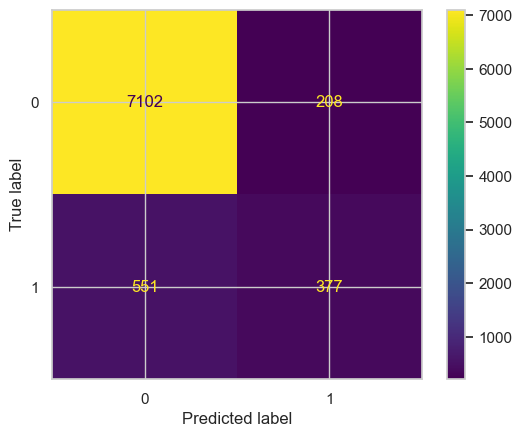

In [32]:
# Crea a matriz de confusión con Sklearn
cmd = ConfusionMatrixDisplay(cm)  
cmd.plot();  # Dibuja la matriz

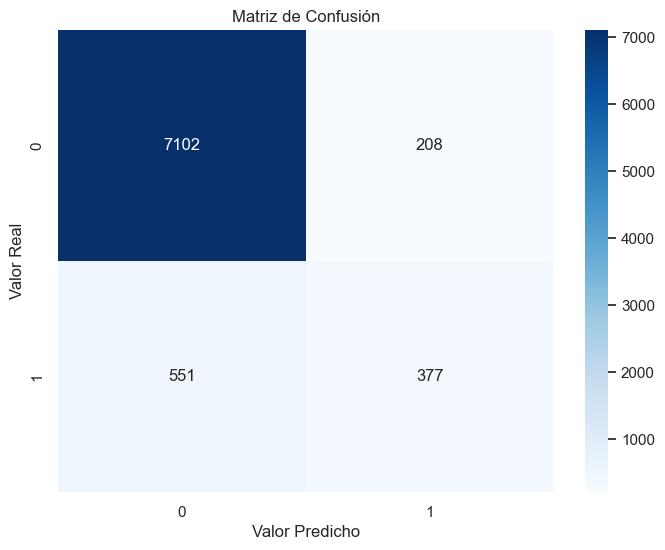

In [33]:
 # Crear matriz de confusión con MatPlotLib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

- Calcular precision, recall y f1 usando classification_report

In [34]:
from sklearn.metrics import classification_report

In [35]:
# Evaluar el modelo
report = classification_report(y_test, y_pred)

print('Reporte de clasificación:')
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.64      0.41      0.50       928

    accuracy                           0.91      8238
   macro avg       0.79      0.69      0.72      8238
weighted avg       0.90      0.91      0.90      8238



#### ROC Curve

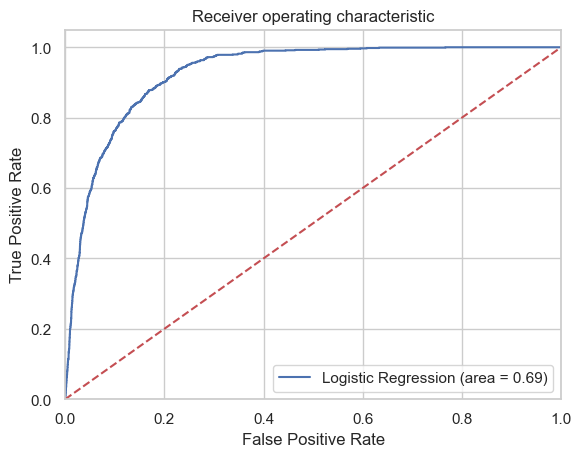

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

La curva receiver operating characteristic (ROC) es otra herramienta común utilizada con los clasificadores binarios. La línea de puntos representa la curva ROC de un clasificador puramente aleatorio; un buen clasificador se mantiene lo más alejado posible de esa línea (hacia la esquina superior izquierda).

### SMOTE Oversampling

Una vez creados nuestros datos de entrenamiento, voy a realizar un muestreo ascendente de la no-suscripción utilizando el algoritmo SMOTE (Synthetic Minority Oversampling Technique). A alto nivel, 

1.   SMOTE: Funciona creando muestras sintéticas de la clase menor (no-suscripción) en lugar de crear copias.
2.   Eligiendo aleatoriamente uno de los k-próximos y utilizándolo para crear una nueva observación similar, pero ajustada aleatoriamente.

In [37]:
!pip install imbalanced-learn




[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [38]:
import imblearn
print(imblearn.__version__)


0.13.0


In [39]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

columns = X_train.columns
os_data_X,os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# revisamos los nros en nuestra data
print("Longitud de data oversampleada: ",len(os_data_X))
print("Numero de no subscripciones en data oversampleada: ",len(os_data_y[os_data_y['y']==0]))
print("Cantidad de subscripciones: ",len(os_data_y[os_data_y['y']==1]))
print("Proporción de no subscripciones en data oversampleada: ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proporción de subscripciones en data oversampleada: ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Longitud de data oversampleada:  58476
Numero de no subscripciones en data oversampleada:  29238
Cantidad de subscripciones:  29238
Proporción de no subscripciones en data oversampleada:  0.5
Proporción de subscripciones en data oversampleada:  0.5


Ahora tenemos unos datos perfectamente equilibrados. Puede que haya notado que he sobremuestreado sólo los datos de entrenamiento, porque al sobremuestrear sólo los datos de entrenamiento, no se utiliza ninguna información de los datos de prueba para crear observaciones sintéticas, por lo tanto, no se filtrará información de los datos de prueba al entrenamiento del modelo.

### Feature Selection

La eliminación recursiva de características (RFE - [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)) se basa en la idea de construir repetidamente un modelo y elegir la característica con mejor o peor rendimiento, apartando la característica y repitiendo el proceso con el resto de las características. Este proceso se aplica hasta que se agotan todas las características del conjunto de datos. El objetivo de la RFE es seleccionar características considerando recursivamente conjuntos de características cada vez más pequeños.

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
data_final_vars=df.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
rfe = RFE(log_reg, n_features_to_select=15)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False  True False False False False False False  True  True  True
  True False  True  True  True False False False False False False False
 False False False False  True False False  True False  True  True  True
  True False  True]
[32 34 27 36 31 28 29 35 20 33  2 13  4 18  1 17 14  5 16 12 15  1  1  1
  1 30  1  1  1 24 37 26 22 21 23 25 11  6  8  7  1 10  9  1  3  1  1  1
  1 19  1]


In [42]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1


In [43]:
print("RFE nos deja con las siguientes variables: ", rfe.feature_names_in_[rfe.support_])

RFE nos deja con las siguientes variables:  ['job_retired' 'marital_married' 'marital_single' 'marital_unknown'
 'education_high.school' 'education_professional.course'
 'education_university.degree' 'education_unknown' 'month_mar' 'month_oct'
 'day_of_week_mon' 'day_of_week_thu' 'day_of_week_tue' 'day_of_week_wed'
 'poutcome_success']


In [44]:
cols = rfe.feature_names_in_[rfe.support_]
X_train_2 = os_data_X[cols]
X_test_2 = X_test[cols]
y_train_2 = os_data_y['y']

#### Train the new model:

In [45]:
log_reg = LogisticRegression()
log_reg.fit(X_train_2, y_train_2)

LogisticRegression()

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
class_names = ['no subscripción', 'si subscripción']

disp = ConfusionMatrixDisplay(log_reg, X_test_2, y_test,
                              display_labels=class_names,
                              cmap=plt.cm.Blues)


print(disp.confusion_matrix)

TypeError: ConfusionMatrixDisplay.__init__() got an unexpected keyword argument 'cmap'

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7310
           1       0.64      0.41      0.50       928

    accuracy                           0.91      8238
   macro avg       0.79      0.69      0.72      8238
weighted avg       0.90      0.91      0.90      8238



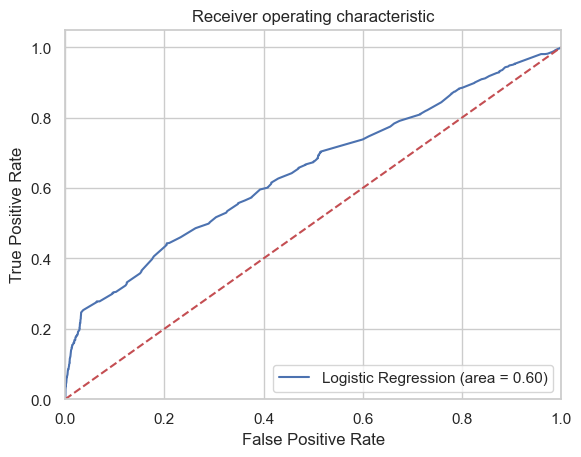

In [50]:
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test_2))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()